# LIBRARY PREPARATION

In [43]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# DATA PREPARATION

In [44]:
# 8:2 ratio
df = pd.read_csv('../Dataset/TSLA_data.csv') # Read data
df = df[['Close']]
df = df.dropna() # Drop NaN values
df = df.reset_index(drop=True) # Reset the index

In [45]:
print(df.dtypes)

Close    float64
dtype: object


# STATIONARY TEST USING AUGMENTED DICKEY-FULLER (ADF)

In [46]:
# ADF Test Function
def adf_test(series,title=''):
    """ Input a time series and an optional title to return an ADF report """

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF Test Statistic','p-value','# Lags used','# Observations']
    out = pd.Series(result[0:4],index = labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis,\nReject the null hypothesi,\n --> Data has no unit root and is STATIONARY")
    else:
        print("\nWeak evidence against the null hypothesis,\nFail to reject the null hypothesis,\n --> nData has a unit root and is NON-STATIONARY")
     

In [47]:
adf_test(df['Close'], 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic        -1.941846
p-value                    0.312639
# Lags used               24.000000
# Observations          1810.000000
Critical Value (1%)       -3.433968
Critical Value (5%)       -2.863138
Critical Value (10%)      -2.567621

Weak evidence against the null hypothesis,
Fail to reject the null hypothesis,
 --> nData has a unit root and is NON-STATIONARY


# CONVERT TO STATIONARY TIME SERIES

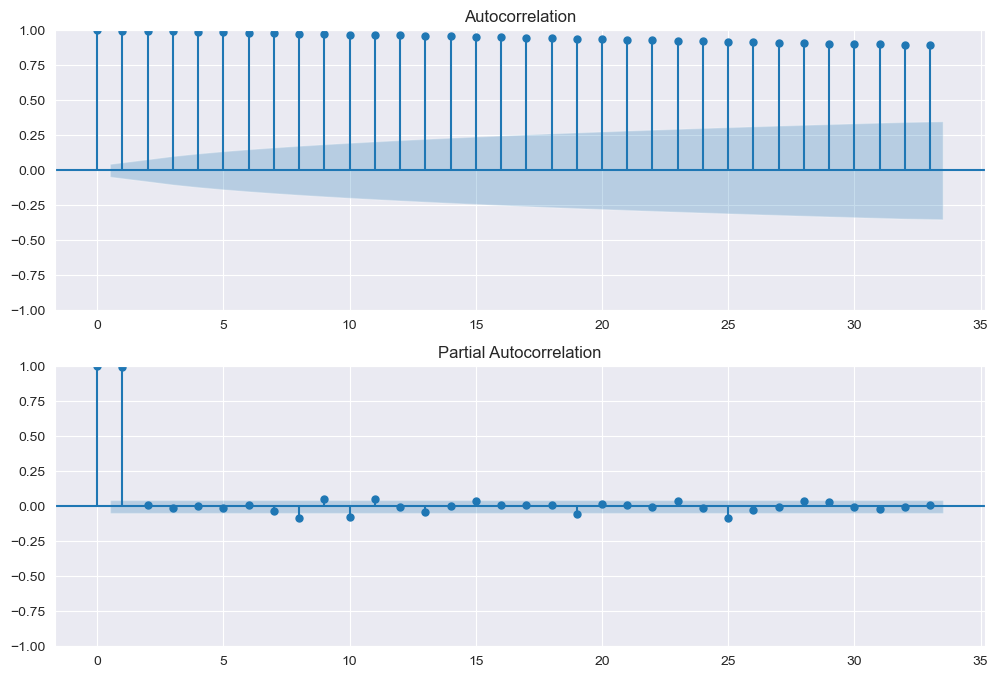

In [48]:
# Plotting the AutoCorrelation Function and Partial AutoCorrelation Function to determine ARIMA parameters.
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Close'], ax=axes[0])
plot_pacf(df['Close'], ax=axes[1])
plt.show()

In [49]:
log_close = np.log(df['Close'])
log_diff = log_close.diff().dropna()

In [50]:
adf_test(log_diff, 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic       -43.611495
p-value                    0.000000
# Lags used                0.000000
# Observations          1833.000000
Critical Value (1%)       -3.433923
Critical Value (5%)       -2.863118
Critical Value (10%)      -2.567610

Strong evidence against the null hypothesis,
Reject the null hypothesi,
 --> Data has no unit root and is STATIONARY


# TRAIN-TEST SPLIT

In [51]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# TRAINING PROCESSS

In [52]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   max_p=5, max_q=5, stationary=False,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()

# Forecast the test_data
forecast = model_fit.forecast(steps=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9883.617, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9882.286, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9882.739, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9882.791, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9880.733, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.674 seconds


In [53]:
### 1. Create sequence index
last_index =  df.index[-1]

# a) For 30 Days
last_data_30 = pd.RangeIndex(start = last_index, stop = last_index + 30, step = 1)

# b) For 60 Days
last_data_60 = pd.RangeIndex(start = last_index, stop = last_index + 60, step = 1)

# c) For 90 Days
last_data_90 = pd.RangeIndex(start = last_index, stop = last_index + 90, step = 1)


### 2. Create array

# a) Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# b) Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

# c) Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)


### 3. Predict closing prices

# a) Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

# a) Predict the closing prices for the next 60 days
y_next_60_days = model_fit.forecast(steps=len(x_next_60_days))

# a) Predict the closing prices for the next 90 days
y_next_90_days = model_fit.forecast(steps=len(x_next_90_days))


### 4. Print result

# a) Print the predicted closing prices for the next 30 days
print('Predicted Closing Prices for the next 30 days:')
print(y_next_30_days)

# b) Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days[30:60])

# c) Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days[60:90])

Predicted Closing Prices for the next 30 days:
1468    200.455415
1469    200.697472
1470    200.559070
1471    200.638205
1472    200.592958
1473    200.618829
1474    200.604036
1475    200.612494
1476    200.607658
1477    200.610423
1478    200.608842
1479    200.609746
1480    200.609229
1481    200.609525
1482    200.609356
1483    200.609453
1484    200.609397
1485    200.609429
1486    200.609411
1487    200.609421
1488    200.609415
1489    200.609419
1490    200.609417
1491    200.609418
1492    200.609417
1493    200.609418
1494    200.609417
1495    200.609418
1496    200.609417
1497    200.609417
Name: predicted_mean, dtype: float64
Predicted closing prices for the next 60 days:
1498    200.609417
1499    200.609417
1500    200.609417
1501    200.609417
1502    200.609417
1503    200.609417
1504    200.609417
1505    200.609417
1506    200.609417
1507    200.609417
1508    200.609417
1509    200.609417
1510    200.609417
1511    200.609417
1512    200.609417
1513    200.60

# EVALUATION

In [54]:
# Calculate performance metrics
test_mae = mean_absolute_error(test_data, forecast)
test_mape = mean_absolute_percentage_error(test_data, forecast)
test_rmse = sqrt(mean_squared_error(test_data, forecast))
test_mse = mean_squared_error(test_data, forecast)

# Calculate Mean Absolute Scaled Error (MASE)
naive_forecast = train_data.shift(1).dropna()
mase_denom = mean_absolute_error(train_data[1:], naive_forecast)
test_mase = test_mae / mase_denom

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)
print('MSE:', test_mse)
print('MASE:', test_mase)

MAE: 61.24573182394081
RMSE: 89.07569149567233
MAPE: 0.20662874720362312
MSE: 7934.478815432192
MASE: 14.882252682253089


# VISUALIZATION

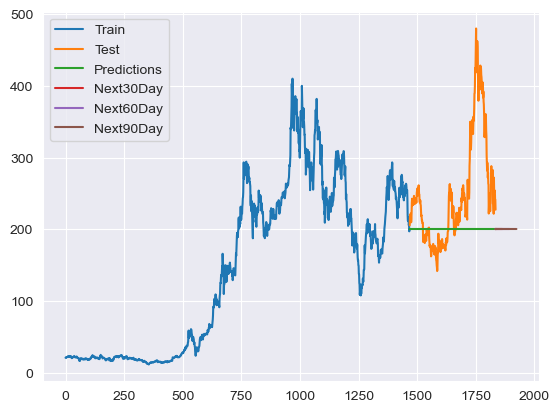

In [55]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, forecast)
plt.plot(last_data_30, y_next_30_days)
plt.plot(last_data_60, y_next_60_days)
plt.plot(last_data_90, y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

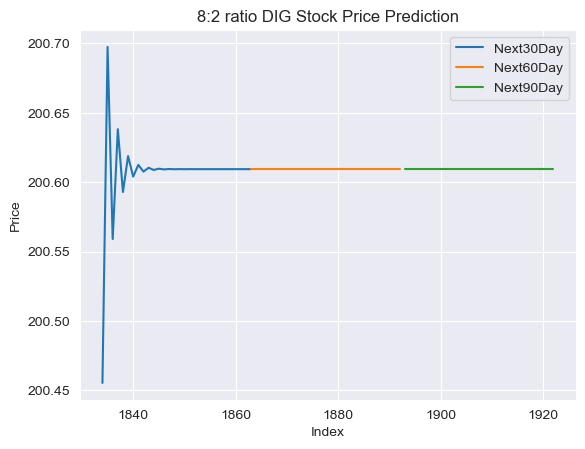

In [56]:
plt.plot(last_data_30, y_next_30_days)
plt.plot(range(last_data_30[-1], last_data_60[-1]), y_next_60_days[30:])
plt.plot(range(last_data_60[-1], last_data_90[-1]), y_next_90_days[60:])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('8:2 ratio DIG Stock Price Prediction')
plt.legend(['Next30Day', 'Next60Day', 'Next90Day'])

plt.show()